## Bayesian model averaging

# Intuition

**FIGURE PLACEHOLDER:** ![Bayesian model averaging](image_placeholder)

# Notation


**Model Averaging** is a technique used in statistical modeling that combines predictions from multiple models to improve accuracy and robustness. Instead of selecting a single best model, model averaging considers the contribution of several models, weighted by their plausibility, and uses them to generate a more reliable prediction.

The basic idea behind model averaging is that different models may capture different aspects of the underlying data or process, and combining them can lead to better overall performance, especially when some models perform better in some regions of the data and worse in others.



## Theoretical Background

Let’s assume we have a set of models $M_1, M_2, \dots, M_K$ and we want to predict a value for a new observation $y^*$ based on the models. For each model $M_k$, we calculate a prediction, denoted as $\hat{y}^*_k$. 

The **model-averaged prediction** is typically given by the weighted sum of the predictions from each model:

$$
\hat{y}^*_{\text{avg}} = \sum_{k=1}^{K} w_k \hat{y}^*_k
$$

Where:
- $w_k$ is the weight associated with model $M_k$, which reflects how likely or good the model is at describing the data.
- $\hat{y}^*_k$ is the prediction made by model $M_k$ for the new data point.


## Weights in Model Averaging

The weights $w_k$ can be assigned based on various criteria:
1. **Bayesian Model Averaging (BMA)**: In the Bayesian framework, the weights correspond to the posterior model probabilities, i.e., the probability of each model given the data:

   $$ 
   w_k = P(M_k | D) 
   $$

   Where $P(M_k | D)$ is the posterior probability of model $M_k$ given the observed data $D$.

2. **Do we want to include AIC and BIC???**

**Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC)**: In a frequentist context, the weights are often computed based on the relative likelihood of each model, using information criteria like AIC or BIC. The models with lower AIC/BIC values are considered to be more likely and receive higher weights.

   $$ 
   w_k = \frac{e^{-\frac{1}{2} \Delta \text{AIC}_k}}{\sum_{j=1}^K e^{-\frac{1}{2} \Delta \text{AIC}_j}} 
   $$

   Where $\Delta \text{AIC}_k = \text{AIC}_k - \min(\text{AIC})$, and $\text{AIC}_k$ is the AIC of model $k$.


## Why Model Averaging Works



BMA accounts for the uncertainty involved in selecting the model, **preserving the uncertainty about models**.

1. **Reduced Risk of Overfitting**: By averaging over multiple models, we avoid overfitting to any one model. Even if one model fits the training data well but fails to generalize, other models can provide complementary information, reducing the overall risk of overfitting.
  
2. **Improved Accuracy**: If models make different types of errors, combining their predictions can reduce the variance and bias, leading to more accurate predictions.

3. **Incorporating Model Uncertainty**: In cases where model uncertainty is high, model averaging incorporates this uncertainty by using multiple models and averaging their predictions, rather than relying on a single model.



- **Advantages of BMA**
    - Accounts for model uncertainty, leading to more robust inference.
    - Prevents overconfidence in a single model when multiple models have similar posterior probabilities.
    - Helps mitigate overfitting, especially with limited data.

# Example

We aim to determine whether a genetic variant has a causal effect ($\theta$) on height. Instead of selecting a single best model, we consider multiple models with different effect sizes and use Bayesian Model Averaging (BMA) to weigh them based on their posterior probabilities.

## Model Definitions

We define several models representing different assumptions about the effect size:

- $M_1$: No effect ($\theta = 0$)

- $M_2$: Strong effect ($\theta = 2$)

- $M_3$: Moderate effect ($\theta = 1$)

- $M_4$: Weak effect ($\theta = 0.5$)

- $M_5$: The effect $\theta$ is uncertain and follows a continuous prior (e.g., Normal prior $\theta \sim \mathcal{N}(0,1)$)

Each model is assigned a prior probability $P(M_i)$, and after observing genotype and height data, we update these probabilities using Bayes' theorem.


Instead of selecting the most probable model, BMA computes a weighted average estimate of $\theta$, incorporating all models under consideration:
$$
P(\theta | D) = \sum_i P(\theta | M_i, D) P(M_i | D)
$$

For prediction, the expected height given a new genotype is:
$$
E(Y_{i+1}|D, x_{i+1}) = \sum_j E[Y|M_j, D, x_{i+1}]P(M_j|D)
$$

which integrates over all models rather than relying on a single one.

By using BMA, we obtain a more comprehensive understanding of the genetic effect on height rather than relying on a single assumption about $\theta$. 

In [169]:
rm(list=ls())
library(BMA)
library(MASS)
set.seed(3)
baseline <- 170
sd_y <- 1  # Standard deviation of the trait (e.g., variability in height measurement within the population)
genotype1 <- c(0,1,1,2,0)
genotype2 <- c(1,2,0,0,0)
n = length(genotype1)
genotype <- matrix(c(genotype1, genotype2), ncol=2) # two variants
colnames(genotype)<- paste0("X", 1:2)
true_beta <- c(2,0)
height_values <- rnorm(n, mean = baseline + genotype %*% true_beta, sd = sd_y)
data <- data.frame(genotype1 = genotype1, genotype2 = genotype2, height = height_values)
data

genotype1,genotype2,height
<dbl>,<dbl>,<dbl>
0,1,169
1,2,172
1,0,172
2,0,173
0,0,170


In [170]:
# Perform BMA for linear regression
bma_result <- bicreg(genotype, height_values, strict=FALSE)

# Summary of the BMA results
summary(bma_result)


Call:
bicreg(x = genotype, y = height_values, strict = FALSE)


  2  models were selected
 Best  2  models (cumulative posterior probability =  1 ): 

           p!=0    EV       SD     model 1  model 2
Intercept  100.0  169.8688  0.529  169.831  169.942
X1         100.0    1.7152  0.448    1.723    1.701
X2          33.8   -0.0523  0.283      .     -0.155
                                                   
nVar                                   1        2  
r2                                   0.850    0.858
BIC                                 -7.877   -6.531
post prob                            0.662    0.338


In [171]:
# Print the posterior probabilities of each model
print(bma_result$postprob)

# Print posterior inclusion probabilities for each variable
print(bma_result$probne0)


[1] 0.662 0.338
[1] 100.0  33.8


In [172]:
new_genotype1 <- c(0,1,1)
new_genotype2 <- c(1,2,1)
# Make predictions using BMA
new_data <- matrix(c(new_genotype1, new_genotype2), ncol=2)
colnames(new_data) <- paste0("X", 1:2)
predictions <- predict(bma_result, newdata=new_data)
predictions


,0.1,0.5,0.9
1,169,170,171
2,170,171,173
3,170,172,173


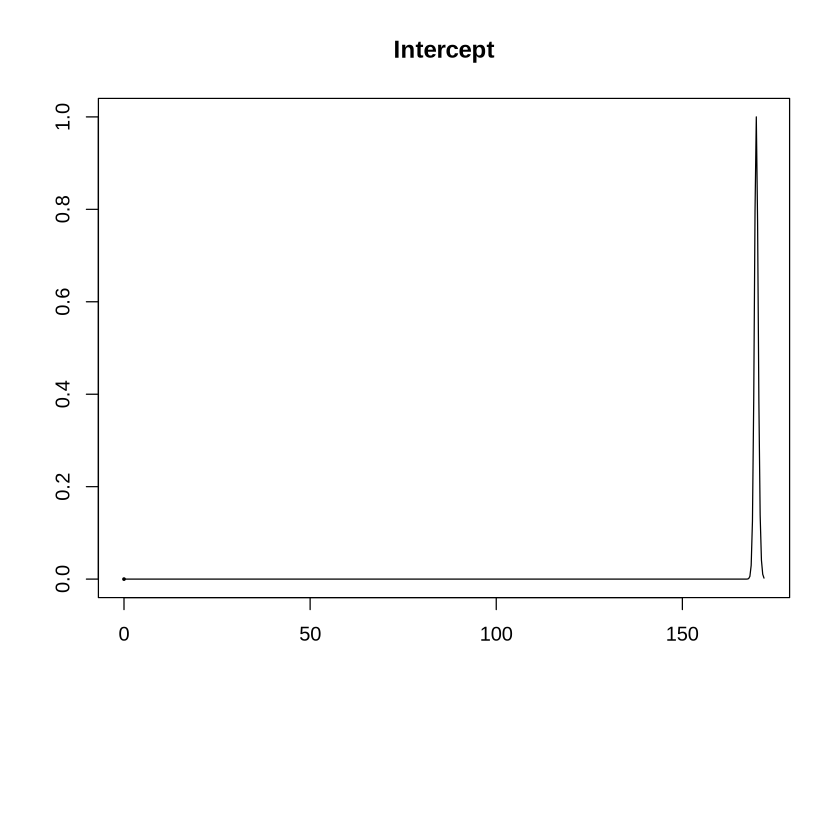

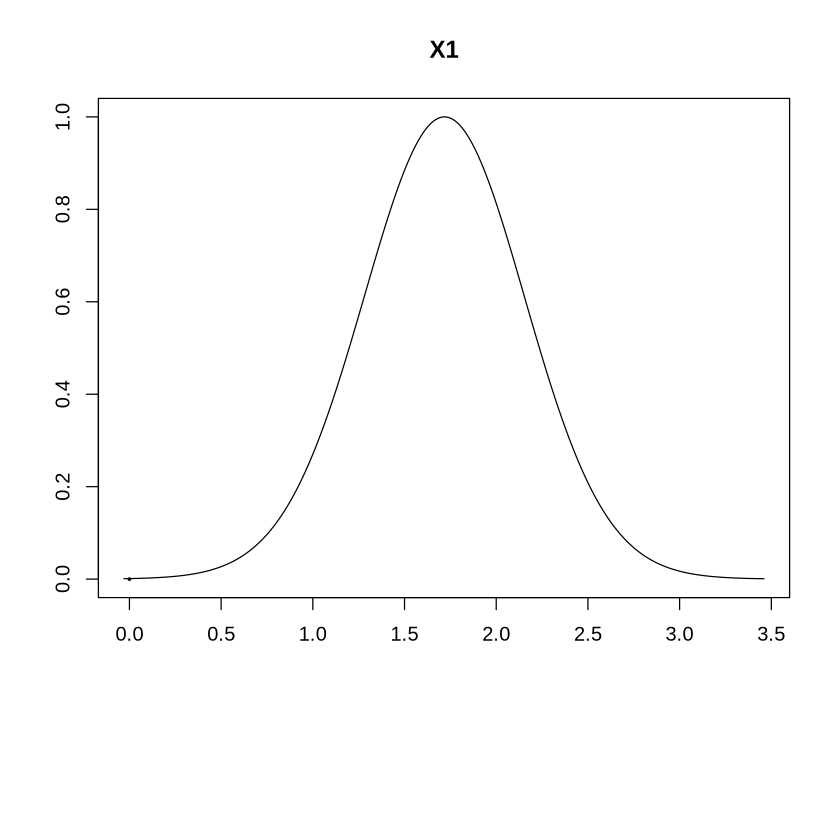

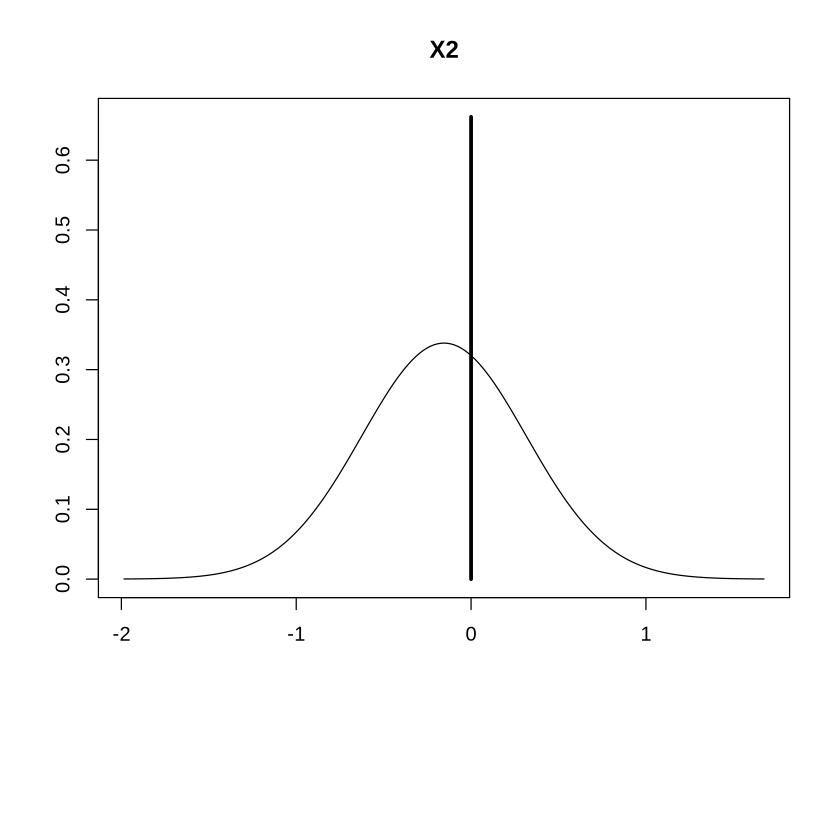

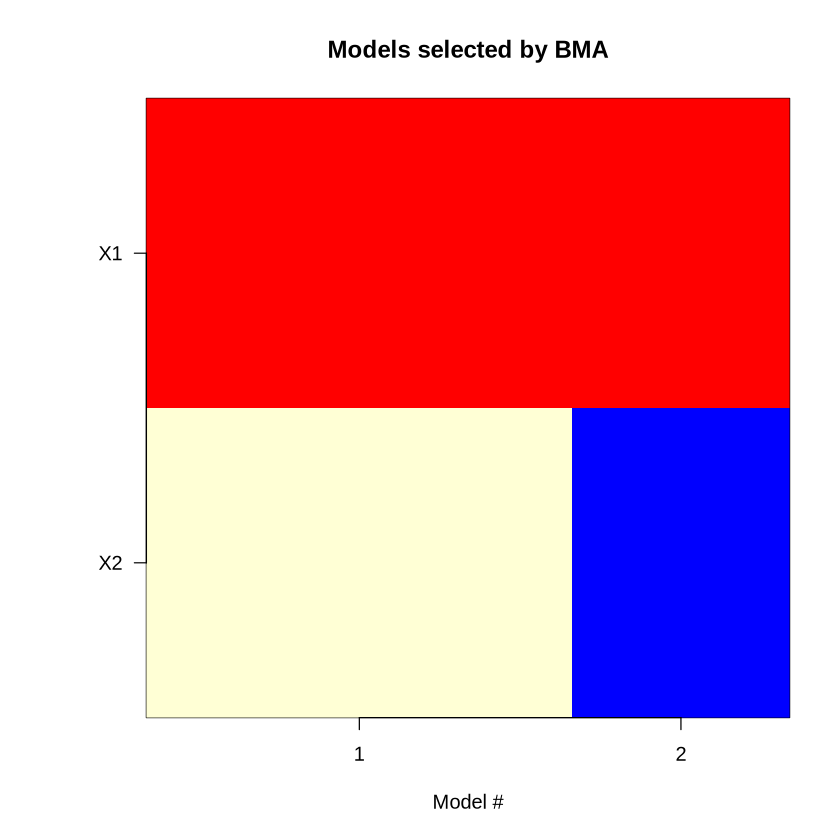

In [173]:
# Visualize the posterior model probabilities for the top models
par(mar=c(10, 4, 4, 2) + 0.1)
plot(bma_result, mfrow=c(1, 1))

# Visualize the posterior inclusion probabilities for each variable
imageplot.bma(bma_result)